## Modeling - Citation Prediction

In [1]:
# basic
import json
import pdb
import ast
from tqdm import tqdm
from collections import Counter

import numpy as np
import pandas as pd

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.neural_network import MLPRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# custom
from utils import *

SEED = 0

/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load Data

In [2]:
YEAR = 2017

works = pd.read_csv(f'./data/{YEAR}/works.{YEAR}.v1.csv')
authors = pd.read_csv(f'./data/{YEAR}/authors.{YEAR}.v1.csv')
venues = pd.read_csv(f'./data/{YEAR}/venues.{YEAR}.v1.csv')
insts = pd.read_csv(f'./data/{YEAR}/insts.{YEAR}.v1.csv')

In [3]:
works = preprocess_works(works, YEAR, 2022)

In [4]:
# works
print (works.shape)
works.head()

(145694, 15)


,id,doi,title,type,publication_date,host_venue,open_access_is_oa,open_access_oa_status,authorships,page_count,cited_by_count,concepts,referenced_works,abstract,counts_by_year
0,W2555618208,https://doi.org/10.1109/cvpr.2017.691,Multi-view 3D Object Detection Network for Aut...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2119051707, [I99065089]], [A2151001937, [I9...",-1,1409,"[[C131979681, 0.86888766], [C41008148, 0.77201...","[W7746136, W1536680647, W1914646313, W19466097...",This paper aims at high-accuracy 3D object det...,"[(2017, 13), (2018, 109), (2019, 308), (2020, ..."
1,W2557641257,https://doi.org/10.1109/cvpr.2017.733,ECO: Efficient Convolution Operators for Tracking,proceedings-article,2017-07-21,V4306417987,True,green,"[[A260882311, [I102134673]], [A2557978175, [I1...",-1,1322,"[[C63479239, 0.8030945], [C68339613, 0.7788200...","[W1857884451, W1892578678, W1904671147, W19157...","In recent years, Discriminative Correlation Fi...","[(2017, 9), (2018, 133), (2019, 303), (2020, 3..."
2,W2963709863,https://doi.org/10.1109/cvpr.2017.241,Learning from Simulated and Unsupervised Image...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2183241032, [I1311269955]], [A2798413642, [...",-1,1277,"[[C41008148, 0.8212265], [C2779803651, 0.78661...","[W1922126009, W1950149599, W1995694455, W20012...","With recent progress in graphics, it has becom...","[(2017, 55), (2018, 251), (2019, 356), (2020, ..."
3,W2594519801,https://doi.org/10.1109/cvpr.2017.261,ScanNet: Richly-Annotated 3D Reconstructions o...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2158018495, [I97018004]], [A2111957820, [I2...",-1,1116,"[[C41008148, 0.8516614], [C82990744, 0.6491697...","[W218762409, W1509835260, W1565402342, W159436...",A key requirement for leveraging supervised de...,"[(2017, 12), (2018, 76), (2019, 226), (2020, 3..."
4,W2561715562,https://doi.org/10.1109/cvpr.2017.215,CLEVR: A Diagnostic Dataset for Compositional ...,proceedings-article,2017-07-01,V4306417987,True,green,"[[A2345205178, [I97018004]], [A1988254826, [I2...",-1,1085,"[[C41008148, 0.7745689], [C130440534, 0.751482...","[W1933349210, W1983927101, W1996418862, W20646...",When building artificial intelligence systems ...,"[(2017, 38), (2018, 146), (2019, 232), (2020, ..."


### Feature Extraction

In [5]:
df = pd.DataFrame()
# features
df['publication_month'] = works['publication_date'].map(lambda x: int(x.split('-')[1]))
df['open_access_is_oa'] = works['open_access_is_oa']
df['no_of_authors'] = works['authorships'].map(lambda x: len(x))
df['no_of_referenced_works'] = works['referenced_works'].map(len)
df['avg_counts_by_year'] = works['counts_by_year'].map(lambda x: np.mean(np.array(x)[:, 1] if len(x) else 0))

# target variable
df['cited_by_count'] = works['cited_by_count']

In [5]:
df.head()

,publication_month,open_access_is_oa,no_of_authors,no_of_referenced_works,avg_counts_by_year,cited_by_count
0,6,False,3,31,602.909091,6636
1,12,False,3,11,197.727273,2177
2,6,True,3,21,179.000000,1970
3,12,True,5,29,171.545455,1888
4,1,True,5,16,150.090909,1655


In [45]:
# # normalize
# scaler = StandardScaler()
# X_normalized = scaler.fit_transform(X)

### Regression

In [66]:
X = df.drop(columns=['cited_by_count'])
y = df['cited_by_count']
SEED = 0

In [67]:
# regression analysis

def print_metric(metric_name, metric_list):
    mean, std = np.mean(metric_list), np.std(metric_list)
    print (f"  - {metric_name}: {np.round(mean, 3)} +/- {np.round(std, 3)}")
    return

reg_models = {
    'Linear Regression': LinearRegression(),
    # 'GradientBoostingRegressor': GradientBoostingRegressor(),
    # 'SGDRegressor': SGDRegressor(),
    # 'XGBRegressor': XGBRegressor(),
    # 'MLPRegressor': MLPRegressor(random_state=SEED, max_iter=100),
}

for model_name, model in reg_models.items():
    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    train_rmse, test_rmse = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_train)
        rmse = mean_squared_error(y_true=y_train, y_pred=y_pred, squared=False)
        train_rmse.append(rmse)

        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
        test_rmse.append(rmse)

    print (f"{model_name}:")
    print_metric('Train RMSE', train_rmse)
    print_metric('Test RMSE', test_rmse)

Linear Regression:
  - Train RMSE: 5.623 +/- 0.085
  - Test RMSE: 5.896 +/- 0.619


Feature: 0  Score: ('publication_month', -0.013388896463560361)
Feature: 1  Score: ('open_access_is_oa', -0.21489938785071327)
Feature: 2  Score: ('no_of_authors', -0.08140742553037128)
Feature: 3  Score: ('no_of_referenced_works', -0.05855078592689508)
Feature: 4  Score: ('avg_counts_by_year', 10.430028947845738)
Feature: 5  Score: ('cited_by_count_class', 3.695162046982413)


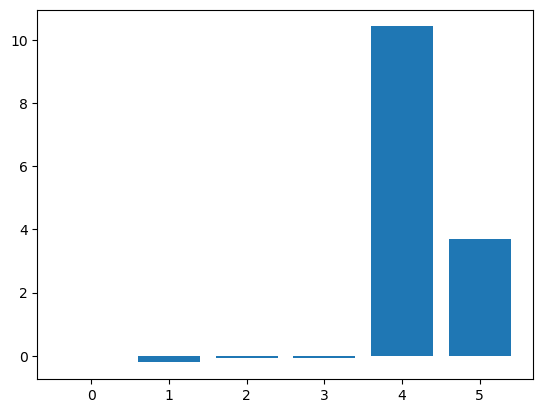

In [72]:
# get importance for linear regression
importance = model.coef_
for i,v in enumerate(zip(X.columns, importance)):
    print('Feature: {}  Score: {}' .format(i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))] ,importance)
plt.show()

### Classification

In [46]:
def bin_citation_count(count):
    if count <= 25:
        return 0
    elif count <= 50:
        return 1
    elif count <= 100:
        return 2
    elif count <= 200:
        return 3
    elif count > 200:
        return 4
    
df['cited_by_count_class'] = df['cited_by_count'].map(bin_citation_count)

In [47]:
X = df.drop(columns=['cited_by_count'])
y = df['cited_by_count_class']

In [61]:
# classification analysis

clf_models = {
    'LogisticRegression': LogisticRegression(n_jobs=-1),
    # 'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    # 'GaussianNB': GaussianNB(),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(),
    # 'SVC': SVC(random_state=SEED, max_iter=100),
    # 'MLPClassifier': MLPClassifier(random_state=SEED, max_iter=100),
}

for model_name, model in clf_models.items():
    kf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
    train_acc, test_acc = [], []
    train_f1, test_f1 = [], []
    for train_index, test_index in tqdm(kf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_train)
        acc = metrics.accuracy_score(y_true=y_train, y_pred=y_pred)
        f1 = metrics.f1_score(y_true=y_train, y_pred=y_pred, average='weighted')
        train_acc.append(acc*100)
        train_f1.append(f1)

        y_pred = model.predict(X_test)
        acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
        f1 = metrics.f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
        test_acc.append(acc*100)
        test_f1.append(f1)
    print (f"{model_name}:")
    print_metric('Train Accuracy (in %)', train_acc)
    print_metric('Train F1 ', train_f1)
    print_metric('Test Accuracy (in %)', test_acc)
    print_metric('Test F1 ', test_f1)

0it [00:00, ?it/s]/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
1it [00:01,  1.91s/it]/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

LogisticRegression:
  - Train Accuracy (in %): 99.485 +/- 0.01
  - Train F1 : 0.995 +/- 0.0
  - Test Accuracy (in %): 99.493 +/- 0.031
  - Test F1 : 0.995 +/- 0.0


## rough

<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

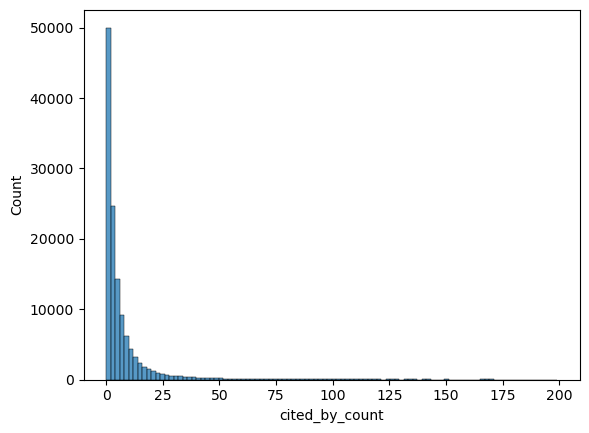

In [33]:
temp = df[df['cited_by_count']<200]
sns.histplot(data=temp, x="cited_by_count", bins=100)

<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

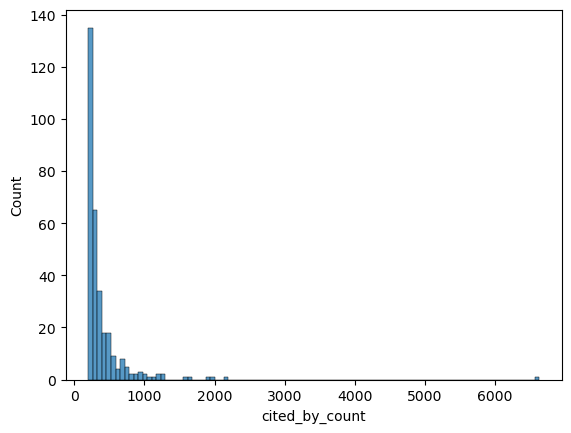

In [38]:
temp = df[df['cited_by_count']>200]
sns.histplot(data=temp, x="cited_by_count", bins=100)